In [ ]:
#Stage D: Understanding 

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# load libraries needed

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from tqdm import tqdm
from keras.preprocessing import image
from keras.utils import load_img, img_to_array

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization

In [4]:
# load data
train_df = pd.read_csv('/kaggle/input/planets-dataset/planet/planet/train_classes.csv')
test_df = pd.read_csv('/kaggle/input/planets-dataset/planet/planet/sample_submission.csv')

In [5]:
# path to the train and test images
test_image_base_path = '/kaggle/input/planets-dataset/planet/planet/test-jpg/'
train_image_base_path = '/kaggle/input/planets-dataset/planet/planet/train-jpg/'
additional_test_images = '/kaggle/input/planets-dataset/test-jpg-additional/test-jpg-additional/'

In [6]:
# show train data
train_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [7]:
# show part of test data
test_df.head()

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


## Exploratory Data Analysis (EDA)

In [8]:
# shape of the train and test data
print('The shape of the train data:', train_df.shape)
print('The shape of the test data:', test_df.shape)

The shape of the train data: (40479, 2)
The shape of the test data: (61191, 2)


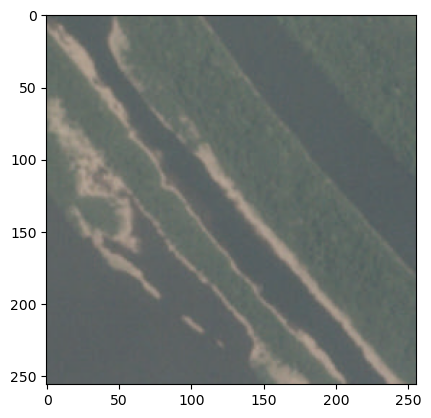

In [9]:
# display an image in the dataset
image = 'train_20.jpg'
img = cv2.imread(train_image_base_path +'/' + image)
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img1)

In [10]:
print('Shape of image', img1.shape)

Shape of image (256, 256, 3)


## Data Preprocessing

In [11]:
# build list with unique labels
label_list = []
for tag_str in train_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [12]:
# Add onehot features for every label
for label in label_list:
    train_df[label] = train_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
# Display head
train_df.head()

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0


In [13]:
# convert each image in the train data to array
size = 75
train_data = []  
for i in tqdm(range(train_df.shape[0])):
    img = load_img(train_image_base_path + train_df['image_name'][i] +'.jpg', target_size=(size,size,3))
    img = img_to_array(img)
    img = img/255.
    train_data.append(img)

# convert images to arrays
x = np.array(train_data)
y = np.array(train_df.drop(['image_name', 'tags'], axis=1))


# print the shape of the train data
print('Shape of input:', x.shape)
print('Shape of target:', y.shape)

100%|██████████| 40479/40479 [06:28<00:00, 104.20it/s]


Shape of input: (40479, 75, 75, 3)
Shape of target: (40479, 17)


In [14]:
# split the data into train and validation set
x_train, x_val, y_train, y_val = train_test_split(x, y, random_state=10, test_size=0.1)

In [15]:
# print the shape
print(x_train.shape)
print(x_val.shape)

(36431, 75, 75, 3)
(4048, 75, 75, 3)


## Model Training

### Model 1: Custom CNN Model

In [16]:
# custon CNN model (baseline model)

c_model = Sequential()

c_model.add(Conv2D(filters=32, kernel_size=(5, 5), activation="relu", input_shape=(size,size,3)))
c_model.add(BatchNormalization())
c_model.add(MaxPooling2D(pool_size=(2, 2)))
c_model.add(Dropout(0.2))

c_model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
c_model.add(MaxPooling2D(pool_size=(2, 2)))
c_model.add(BatchNormalization())
c_model.add(Dropout(0.2))

c_model.add(Flatten())
c_model.add(Dense(128, activation='relu'))
c_model.add(Dropout(0.5))
c_model.add(Dense(64, activation='relu'))
c_model.add(Dropout(0.5))
c_model.add(Dense(17, activation='sigmoid'))

In [17]:
c_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 71, 71, 32)        2432      
                                                                 
 batch_normalization (BatchN  (None, 71, 71, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 35, 35, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 35, 35, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 64)       0

In [18]:
# compile the model
c_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
# fit (train) the model
c_model.fit(x_train, y_train, batch_size=128, epochs=4, verbose=1, validation_data=(x_val,y_val))

Epoch 1/4
285/285 [==============================] - 386s 1s/step - loss: 0.4500 - accuracy: 0.6146 - val_loss: 0.3527 - val_accuracy: 0.8710
Epoch 2/4
285/285 [==============================] - 375s 1s/step - loss: 0.2477 - accuracy: 0.8349 - val_loss: 0.2266 - val_accuracy: 0.8836
Epoch 3/4
285/285 [==============================] - 374s 1s/step - loss: 0.2220 - accuracy: 0.8548 - val_loss: 0.2562 - val_accuracy: 0.8710
Epoch 4/4
285/285 [==============================] - 374s 1s/step - loss: 0.2061 - accuracy: 0.8543 - val_loss: 0.2464 - val_accuracy: 0.8725


#### Summary
After 4 epochs, an accuracy of 87% was obtained on the validation set

In [28]:
# evaluate the model using fbeta_score
from sklearn.metrics import fbeta_score
valid = c_model.predict(x_val, batch_size=128)
print(fbeta_score(y_val, np.array(valid) > 0.2, beta=2, average='samples'))

32/32 [==============================] - 10s 310ms/step
0.7639598533421545


### Model 2: Transfer Learning with Inception V3

In [19]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model 
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers

    
inceptionv3 = InceptionV3(weights="imagenet", include_top=False, input_shape=(size, size, 3))
    
for layer in inceptionv3.layers:
    layer.trainable = False
    
last_output = inceptionv3.output
model = layers.Flatten()(last_output)
model = layers.Dense(4096, activation="relu")(model)
model = layers.Dropout(0.2)(model)
output = layers.Dense(17, activation="sigmoid")(model)
    
model = Model(inputs=inceptionv3.input, outputs=output)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

87910968/87910968 [==============================] - 1s 0us/step


In [20]:
model_checkpoint = ModelCheckpoint('inceptionv3.h5', monitor="accuracy",verbose=1, save_best_only=True)
model.fit(x_train, y_train, batch_size=100, epochs=4, validation_data=(x_val, y_val), callbacks=[model_checkpoint])

Epoch 1/4
365/365 [==============================] - ETA: 0s - loss: 0.1658 - accuracy: 0.8050
Epoch 1: accuracy improved from -inf to 0.80500, saving model to inceptionv3.h5
365/365 [==============================] - 230s 614ms/step - loss: 0.1658 - accuracy: 0.8050 - val_loss: 0.1408 - val_accuracy: 0.8219
Epoch 2/4
365/365 [==============================] - ETA: 0s - loss: 0.1390 - accuracy: 0.8120
Epoch 2: accuracy improved from 0.80500 to 0.81197, saving model to inceptionv3.h5
365/365 [==============================] - 219s 600ms/step - loss: 0.1390 - accuracy: 0.8120 - val_loss: 0.1379 - val_accuracy: 0.8004
Epoch 3/4
365/365 [==============================] - ETA: 0s - loss: 0.1307 - accuracy: 0.8049
Epoch 3: accuracy did not improve from 0.81197
365/365 [==============================] - 218s 596ms/step - loss: 0.1307 - accuracy: 0.8049 - val_loss: 0.1404 - val_accuracy: 0.8463
Epoch 4/4
365/365 [==============================] - ETA: 0s - loss: 0.1222 - accuracy: 0.7994
Epoch

In [21]:
# evaluate model with fbeta_score
from sklearn.metrics import fbeta_score
valid1 = model.predict(x_val, batch_size=128)
print(fbeta_score(y_val, np.array(valid1) > 0.2, beta=2, average='samples'))

32/32 [==============================] - 19s 559ms/step
0.8762918651070168


#### Making predictions on the test images

In [22]:
# load test images
test_data = []
for image, label in tqdm(test_df[:40669].values, miniters = 1000):
  path = test_image_base_path + image + '.jpg'
  test_data.append(cv2.resize(cv2.imread(path), (75,75)))
for image, label in tqdm(test_df[40669:].values, miniters = 1000):
  add_path = additional_test_images + image + '.jpg'
  test_data.append(cv2.resize(cv2.imread(add_path), (75,75)))

100%|██████████| 20522/20522 [03:07<00:00, 109.70it/s]


In [23]:
# change the images to array
test_data = np.array(test_data,np.float16)/255.0

In [24]:
# print shape of test data
test_data.shape

(61191, 75, 75, 3)

In [25]:
# predict on the test images
test_pred = model.predict(test_data, batch_size = 128)

479/479 [==============================] - 281s 586ms/step


In [26]:
len(test_pred)

61191

In [27]:
# create a list and store the predictions
test_predictions = []
test_predictions.append(test_pred)

In [28]:
result = np.array(test_predictions[0])
for i in range(1,len(test_predictions)):
    result += np.array(test_predictions[i])
result = pd.DataFrame(result, columns = label_list)

In [29]:
test_preds = []
for i in tqdm(range(result.shape[0]), miniters=1000):
    x = result.loc[[i]]
    x = x.apply(lambda x: x > 0.2, axis=1)
    x = x.transpose()
    x = x.loc[x[i] == True]
    ' '.join(list(x.index))
    test_preds.append(' '.join(list(x.index)))

100%|██████████| 61191/61191 [02:00<00:00, 506.24it/s]


In [30]:
test_df['tags'] = test_preds
test_df.to_csv('submission.csv', index=False)

In [31]:
file = pd.read_csv('/kaggle/working/submission.csv')
file.head()

,image_name,tags
0,test_0,primary clear
1,test_1,primary clear
2,test_2,primary water partly_cloudy
3,test_3,primary clear partly_cloudy
4,test_4,primary agriculture water partly_cloudy


In [32]:
file.shape

(61191, 2)